<a href="https://colab.research.google.com/github/MrCharli03/RL_BFRRCE/blob/main/MConPolicyOffPOlicy_blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importamos librerias
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [2]:
#creamos entorno
env = gym.make('Blackjack-v1', sab=True)


In [8]:
#inicializamos Q, las politicas y recompensas
Q_on = {}
Q_off = {}
policy = {}
C = {}
rewards_on = []
rewards_off = []

for player_sum in range(1, 22):
    for dealer_card in range(1, 11):
        for usable_ace in [True, False]:
            state = (player_sum, dealer_card, usable_ace)
            Q_on[state] = np.zeros(2)
            Q_off[state] = np.zeros(2)
            policy[state] = np.random.choice([0, 1])
            C[state] = np.zeros(2)


In [9]:
#generamos los episodios
def generate_episode(env, policy=None, behavior_policy_random=False):
    episode = []
    state = env.reset()[0]
    done = False

    while not done:
        if behavior_policy_random:
            action = np.random.choice([0, 1])
        else:
            action = policy[state]

        next_state, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state

    return episode



In [10]:
#montecarlo on policy (e greedy)
returns_on = {s: {0: [], 1: []} for s in Q_on}

def train_mc_on_policy(n_episodes=50000, gamma=1.0, epsilon=0.1):
    total_reward = 0
    for episode_num in range(n_episodes):
        episode = generate_episode(env, policy)
        G = 0
        visited = set()

        for (state, action, reward) in reversed(episode):
            G = reward + gamma * G
            if (state, action) not in visited:
                visited.add((state, action))
                returns_on[state][action].append(G)
                Q_on[state][action] = np.mean(returns_on[state][action])

                if np.random.rand() < epsilon:
                    policy[state] = np.random.choice([0, 1])
                else:
                    policy[state] = np.argmax(Q_on[state])

        total_reward += sum([r for (_, _, r) in episode])
        rewards_on.append(total_reward / (episode_num + 1))

train_mc_on_policy()



In [11]:
#montecarlo Off Policy (importancia muuestral)
def train_mc_off_policy(n_episodes=50000, gamma=1.0):
    total_reward = 0
    for episode_num in range(n_episodes):
        episode = generate_episode(env, policy, behavior_policy_random=True)

        G = 0
        W = 1
        for (state, action, reward) in reversed(episode):
            G = reward + gamma * G
            C[state][action] += W
            Q_off[state][action] += (W / C[state][action]) * (G - Q_off[state][action])

            if action != np.argmax(policy[state]):
                break

            W *= 1 / 0.5

        total_reward += sum([r for (_, _, r) in episode])
        rewards_off.append(total_reward / (episode_num + 1))

train_mc_off_policy()



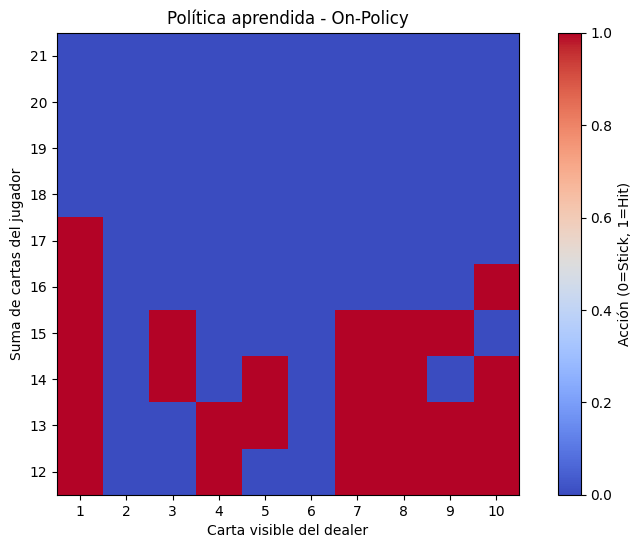

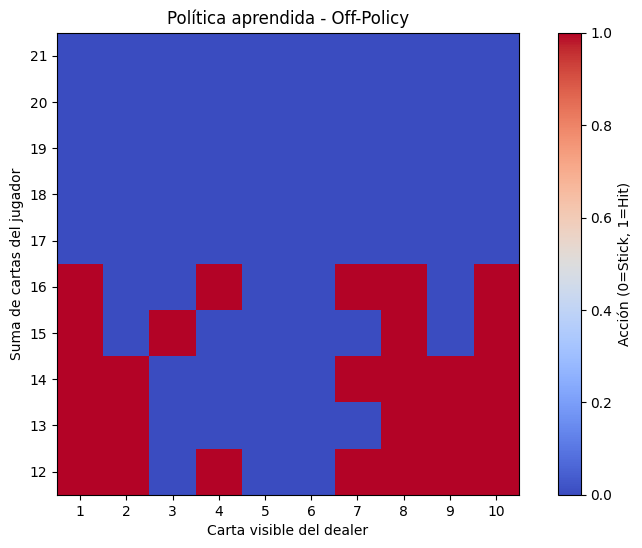

In [12]:
#plot de las politicas aprendidas
def plot_policy(Q, title="Política aprendida"):
    player_sums = np.arange(12, 22)
    dealer_cards = np.arange(1, 11)

    policy_grid = np.zeros((len(player_sums), len(dealer_cards)))

    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = (player_sum, dealer_card, False)
            policy_grid[i, j] = np.argmax(Q[state])

    plt.figure(figsize=(10, 6))
    plt.imshow(policy_grid, cmap="coolwarm", origin="lower")
    plt.colorbar(label="Acción (0=Stick, 1=Hit)")
    plt.xlabel("Carta visible del dealer")
    plt.ylabel("Suma de cartas del jugador")
    plt.xticks(ticks=np.arange(10), labels=dealer_cards)
    plt.yticks(ticks=np.arange(10), labels=player_sums)
    plt.title(title)
    plt.show()

plot_policy(Q_on, "Política aprendida - On-Policy")
plot_policy(Q_off, "Política aprendida - Off-Policy")



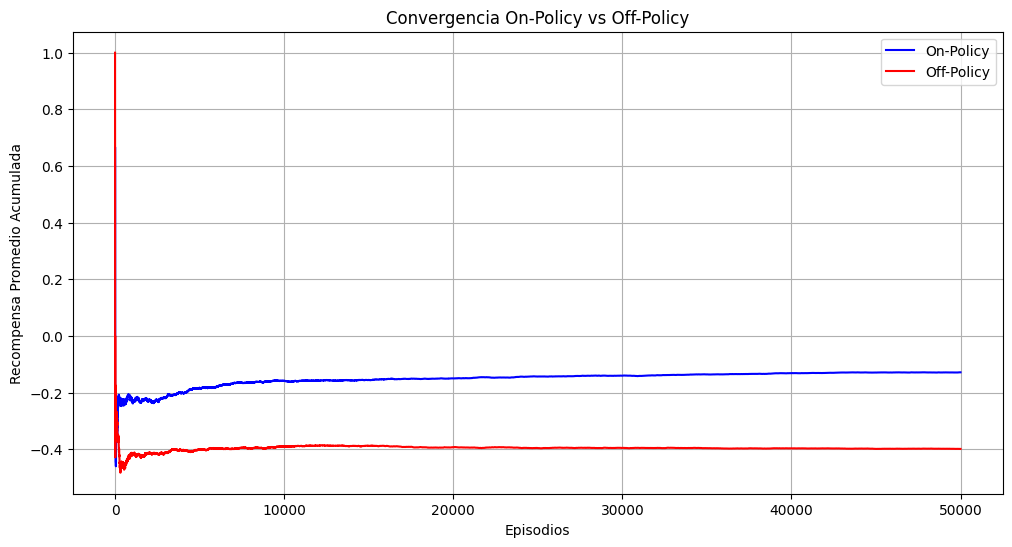

In [13]:
#plot convergencia on policy VS off policy
plt.figure(figsize=(12, 6))
plt.plot(rewards_on, label="On-Policy", color='blue')
plt.plot(rewards_off, label="Off-Policy", color='red')
plt.xlabel("Episodios")
plt.ylabel("Recompensa Promedio Acumulada")
plt.legend()
plt.title("Convergencia On-Policy vs Off-Policy")
plt.grid(True)
plt.show()


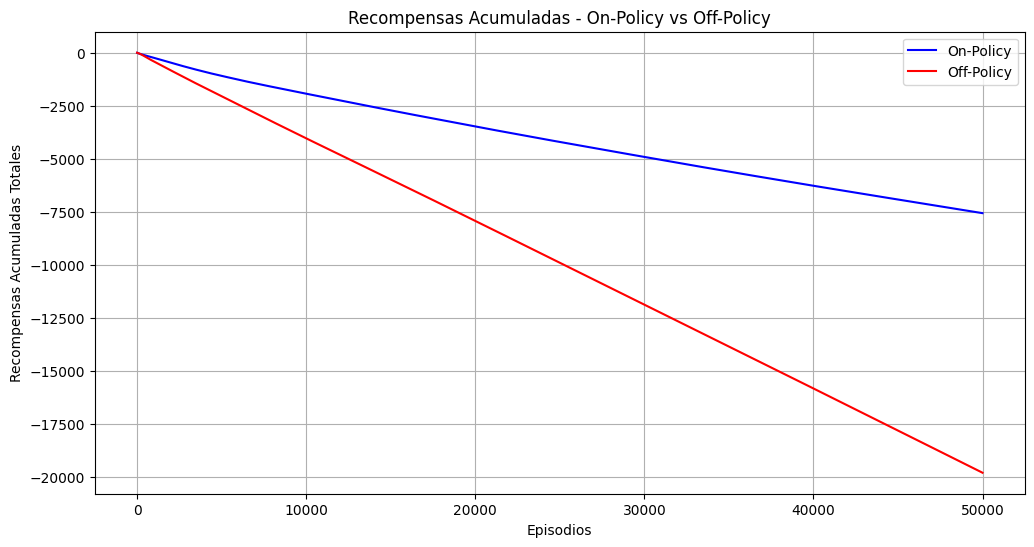

In [16]:
#plot recompensas acumuladas totales
rewards_on_cumulative = np.cumsum(rewards_on)  # Suma acumulada
rewards_off_cumulative = np.cumsum(rewards_off)

plt.figure(figsize=(12, 6))
plt.plot(rewards_on_cumulative, label="On-Policy", color='blue')
plt.plot(rewards_off_cumulative, label="Off-Policy", color='red')
plt.xlabel("Episodios")
plt.ylabel("Recompensas Acumuladas Totales")
plt.legend()
plt.title("Recompensas Acumuladas - On-Policy vs Off-Policy")
plt.grid(True)
plt.show()